## ML Course Project
Name- Muskan Gupta

Roll No- 23565007

Mtech, AI

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, RobustScaler,
                                   FunctionTransformer, QuantileTransformer)

In [7]:
smart_grid_orig=pd.read_csv("/content/SmartGridData.csv")

In [8]:
smart_grid_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [9]:
smart_grid_orig.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [10]:
#Basic quality checks
assert smart_grid_orig.isna().sum().sum() == 0, "some data missing"
stab_fine = max(smart_grid_orig.query("stabf == 'stable'")["stab"]) < 0
stabf_fine = min(smart_grid_orig.query("stabf == 'unstable'")["stab"]) > 0
assert (stab_fine & stabf_fine), "unexpected stab/stabf relationship"

print("As expected, no missing data and `stab` values of less than 0 are labelled 'stable' in `stabf`.")

As expected, no missing data and `stab` values of less than 0 are labelled 'stable' in `stabf`.


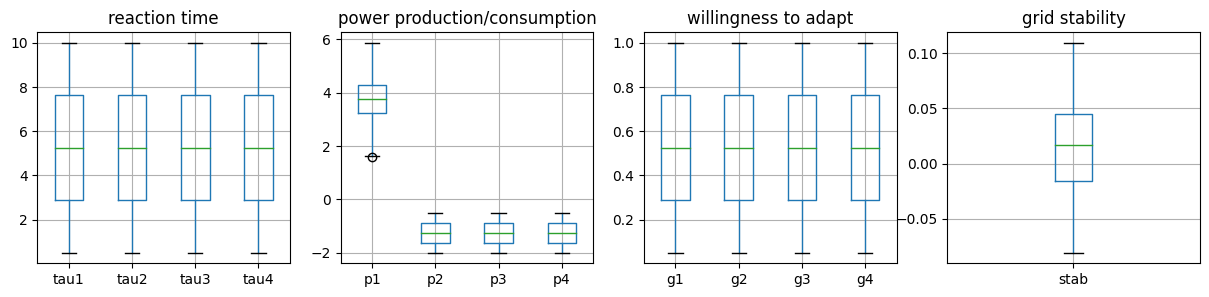

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3))

for axs_ind, feature_group in enumerate(["tau", "p", "g"]):
    smart_grid_orig.boxplot(
        column=[feature_group + str(i + 1) for i in range(4)],
        ax= axs[axs_ind]
    )
smart_grid_orig.boxplot(column="stab", ax= axs[3])

for axs_ind, title in enumerate(["reaction time", "power production/consumption",
                                 "willingness to adapt", "grid stability"]):
    axs[axs_ind].set(title=title);

In [12]:
print(smart_grid_orig["stabf"].value_counts(normalize=True))  # pretty balanced

unstable    0.638
stable      0.362
Name: stabf, dtype: float64


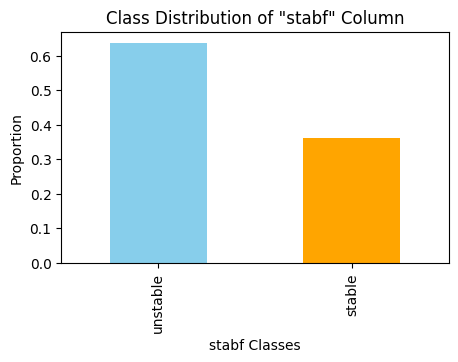

In [25]:
import matplotlib.pyplot as plt

stabf_value_counts = smart_grid_orig["stabf"].value_counts(normalize=True)

# Plotting the bar chart
plt.figure(figsize=(5, 3))
stabf_value_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution of "stabf" Column')
plt.xlabel('stabf Classes')
plt.ylabel('Proportion')
plt.show()

In [26]:
smart_grid = smart_grid_orig.assign(stabf = lambda x: x.stabf.replace({"unstable": 0, "stable": 1}))

smart_grid.columns = (smart_grid.columns
                      .str.replace("tau", "delay")
                      .str.replace("p", "power")
                      .str.replace("g", "adapt"))

In [27]:
smart_grid.head()

,delay1,delay2,delay3,delay4,power1,power2,power3,power4,adapt1,adapt2,adapt3,adapt4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,0


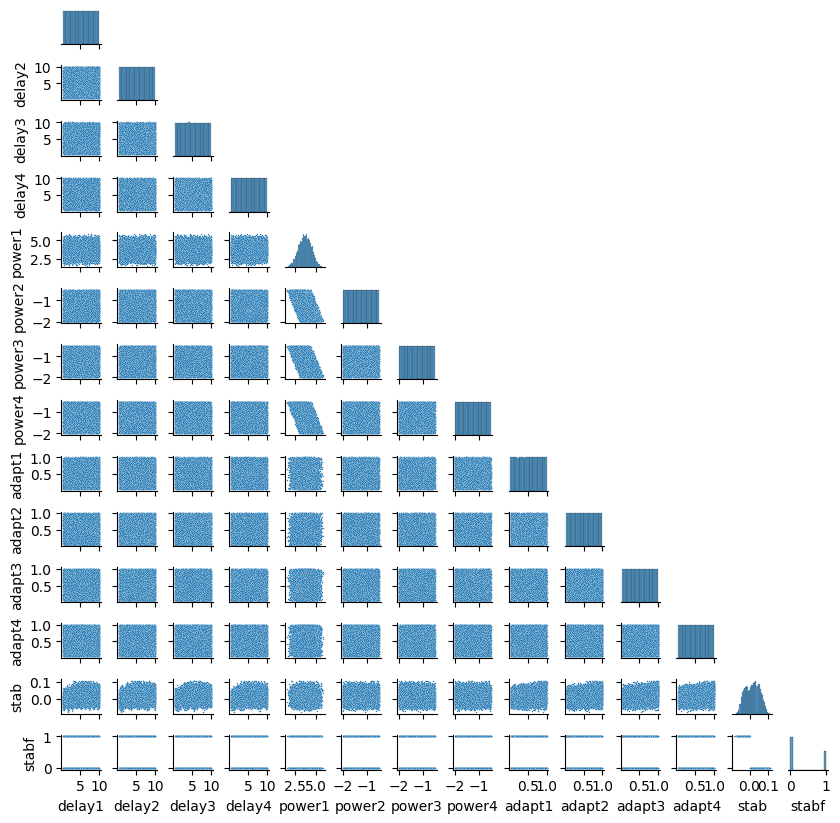

In [15]:
g = sns.PairGrid(smart_grid, diag_sharey=False,
                 corner=True, height=0.6, aspect=1)
g.map_lower(sns.scatterplot, s=1)
g.map_diag(sns.histplot);

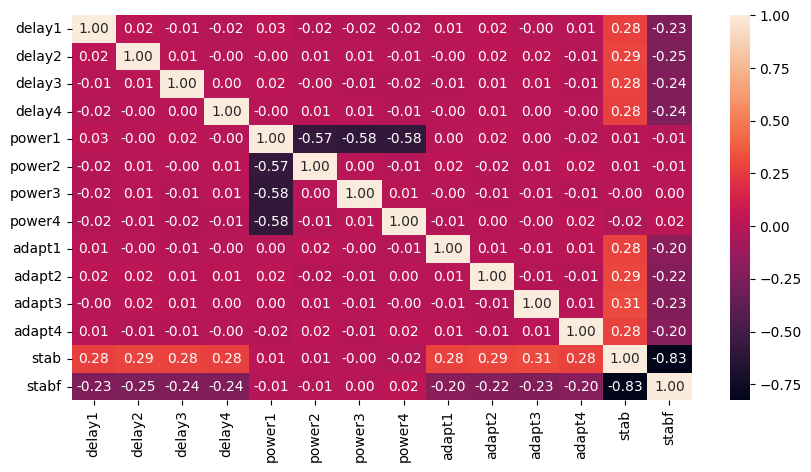

In [16]:
plt.figure(figsize = (10, 5))
sns.heatmap(smart_grid.corr(), fmt=".2f", annot=True);  # default pearson

In [17]:
feat_cols = smart_grid.drop(["stab", "stabf"], axis=1).columns

(pd.DataFrame({
    "variables": smart_grid[feat_cols].columns,
    "VIF": [variance_inflation_factor(smart_grid[feat_cols].values, ind)
            for ind in range(len(feat_cols))]
})
 .rename({"variables": ""}, axis=1)
 .set_index("")
 .transpose()
)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,delay1,delay2,delay3,delay4,power1,power2,power3,power4,adapt1,adapt2,adapt3,adapt4
VIF,4.411883,4.373177,4.387577,4.342155,inf,inf,inf,inf,4.358228,4.39541,4.3677,4.321428


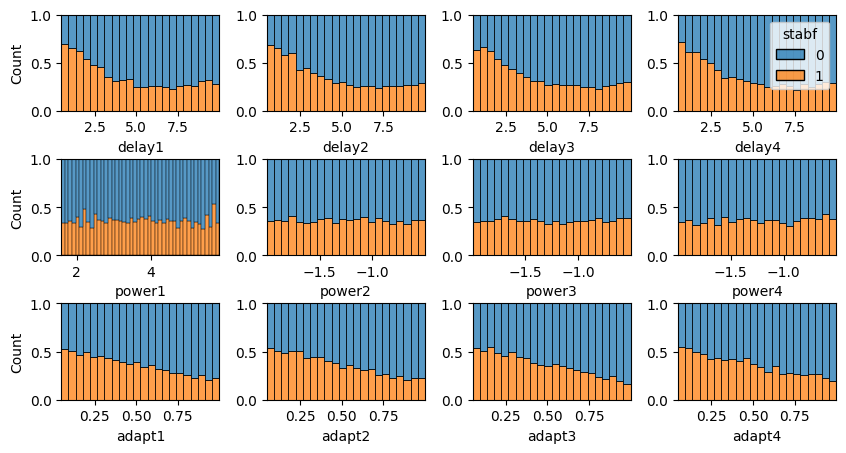

In [18]:
fig, axs = plt.subplots(3, 4, figsize=(10, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

for row_ind, feat_type in enumerate(["delay", "power", "adapt"]):
    for col_ind in range(4):
        show_legend = True if (row_ind == 0) & (col_ind == 3) else False
        sns.histplot(
            smart_grid, x=feat_type + str(col_ind + 1), hue="stabf",
            multiple="fill", legend=show_legend,
            ax=axs[row_ind, col_ind]
        )

        if col_ind > 0:
            axs[row_ind, col_ind].set_ylabel("")

Share of unstable events:


1.   increased with reaction delay (of both producers and
consumers) until roughly 5 seconds, after which the share of unstable events was relatively unaffected by further increases in delay times
2.   increased linearly with willingness to adapt (of both producers and consumers)
3.   still seemed uncorrelated with amount of power produced or consumed

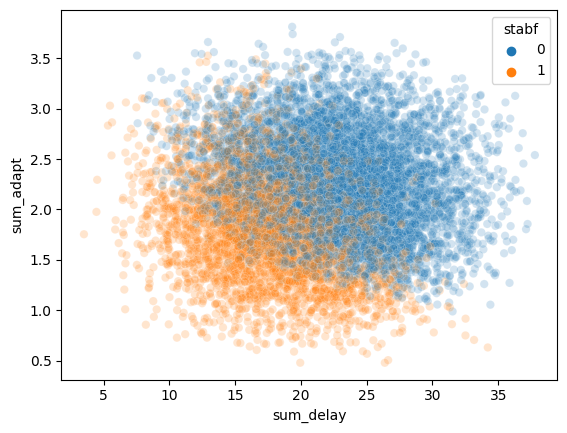

In [19]:
(smart_grid
 .assign(
     sum_delay = lambda x: x["delay1"] + x["delay2"] + x["delay3"] + x["delay4"],
     sum_adapt = lambda x: x["adapt1"] + x["adapt2"] + x["adapt3"] + x["adapt4"]
 )
 .pipe((sns.scatterplot, "data"),
       x="sum_delay", y="sum_adapt", hue="stabf", alpha=0.2)
);

Together, very high or very low sums of delay[x] and adapt[x] values should be indicators of (in)stability. Without further processing, these summarised values would highly correlate with existing features, so I'd rather keep the individual features. In contrast, it might be worth removing all power[x] columns if they're unhelpful.

In [20]:
# model fitting / evaluation / export
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor,
                              VotingClassifier)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (train_test_split, StratifiedKFold, KFold,
                                     cross_validate,
                                     RandomizedSearchCV, GridSearchCV)
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve)

In [32]:
# following conventions, X contains the features and y contains the labels
X = smart_grid.drop(["stab", "stabf"], axis=1)
y = smart_grid[["stab", "stabf"]]

# to ensure that the class distribution is maintained in both the training/validation and testing sets.
X_train_val_, X_test_, y_train_val, y_test = \
    train_test_split(X, y, test_size=0.2, stratify=y["stabf"], random_state=0)

# unsure about how X should be processed at the moment
X_train_val_w_pwr = X_train_val_.drop(["power1"], axis=1)
X_train_val_no_pwr = (X_train_val_
                      .drop(["power1", "power2", "power3", "power4"], axis=1))


clf_y_train_val, clf_y_test = y_train_val["stabf"], y_test["stabf"]

assert all(clf_y_train_val.value_counts(normalize=True) == \
    clf_y_test.value_counts(normalize=True)), \
    "inconsistent class share afer split"

In [33]:
# classifiers
log_reg = LogisticRegression(random_state=1)
rfc = RandomForestClassifier(random_state=1)
knc = KNeighborsClassifier()
dtc= DecisionTreeClassifier()
gNB=GaussianNB()
svc = SVC()


# cross-validation splitters
skf = StratifiedKFold(random_state=1, shuffle=True)
print("For classifiers:", skf)


For classifiers: StratifiedKFold(n_splits=5, random_state=1, shuffle=True)


In [41]:
def get_baseline_scores(est_names, X_train, y_train_val, cv):
    baseline_scores_list = []
    for est_name in est_names:
        pipe = Pipeline(steps=[("scaler", StandardScaler()),
                               ("estimator", globals()[est_name])])

        est_res = cross_validate(pipe,
                                 np.ascontiguousarray(X_train),
                                 y_train_val,
                                 cv=cv, return_train_score=True)
        baseline_scores_list.append(
            pd.DataFrame({"estimator": est_name,
                          "train_score": est_res.get("train_score"),
                          "val_score": est_res.get("test_score"),
                          "fit_time_s": est_res.get("fit_time")
                         }))
    baseline_scores_df = (pd.concat(baseline_scores_list)
                          .sort_values("val_score", ascending=False))
    return baseline_scores_df

def fmt_bl_scores(scores_df, caption):
    metric_cols = ["train_score", "val_score", "fit_time_s"]
    final_df = (scores_df
                .pipe(pd.pivot_table,
                      values=metric_cols,
                      index="estimator",
                      aggfunc={columns: np.mean for columns in metric_cols})
                .sort_values("val_score", ascending=False)

                # display options
                .style.format("{:.1%}", subset=["train_score", "val_score"])
                .set_table_attributes("style='display:inline'")
                .set_caption(caption)._repr_html_())
    return final_df

blc_w_pwr = get_baseline_scores(["log_reg", "rfc", "knc", "svc","dtc", "gNB"],
                                X_train_val_w_pwr, clf_y_train_val, skf)

blc_no_pwr = get_baseline_scores(["log_reg", "rfc", "knc", "svc","dtc", "gNB"],
                                 X_train_val_no_pwr, clf_y_train_val, skf)


In [35]:
from IPython.display import display_html

display_html(
    fmt_bl_scores(blc_w_pwr,
                  "Baseline classifier accuracy (with power columns)") +
    "\xa0" * 2 +  # so both still fit in a line on small screens
    fmt_bl_scores(blc_no_pwr,
                  "Baseline classifier accuracy (no power columns)"),
    raw=True
)

,fit_time_s,train_score,val_score
estimator,,,
svc,0.911765,97.8%,95.7%
rfc,2.161129,100.0%,91.5%
knc,0.011254,91.7%,85.8%
dtc,0.087326,100.0%,84.5%
gNB,0.005616,83.3%,83.4%
log_reg,0.014155,81.5%,81.5%
,fit_time_s,train_score,val_score
estimator,,,
svc,0.484900,98.0%,96.8%


In [38]:
def process_X(X_df):
    final_df = X_df.drop(["power1", "power2", "power3", "power4"], axis=1)
    return final_df

X_train_val = process_X(X_train_val_)
X_test = process_X(X_test_)

Removing the consumer power[x] columns increased accuracy scores for the top four out of five classifiers, and maintained or increased the R2 score for all regressors. To get a better feel for whether the power[x] columns add useful information, I looked at the feature/permutation importance in tree-based models and absolute values of coefficients in L1-penalised linear models for each feature. As examples, I'm showing one type each for classification and regression models:


## Optimise models


In [39]:
def gen_search_eval(estimator_name: str, search_params,
                    pred_task:str, search_mode: str):

    cv = skf
    y_train_val = clf_y_train_val

    pipeline_steps = Pipeline(
        steps=[("transformer", StandardScaler()),
                ("estimator", globals()[estimator_name])]
    )

    common_args = dict(estimator=pipeline_steps, n_jobs=-1,
                       cv=cv, verbose=1,
                       return_train_score=True,  # to check for overfitting
                       error_score="raise")  # if error during fitting
    random_cv = RandomizedSearchCV(param_distributions=search_params,
                                   n_iter=60, random_state=1, **common_args)
    grid_cv = GridSearchCV(param_grid=search_params, **common_args)
    search_cv = grid_cv if search_mode == "grid" else random_cv

    search_cv.fit(X_train_val, y_train_val)
    return search_cv


def fmt_search_res(search_res):
    summary_df = pd.DataFrame(
        {key: search_res.cv_results_.get(key)
         for key in ["params", "rank_test_score",
                     "mean_fit_time", "mean_score_time",
                     "mean_train_score", "mean_test_score",
                     "std_train_score", "std_test_score"]}
    )

    final_df = (pd.DataFrame(summary_df["params"].tolist())  # expand params
                .reset_index()
                .merge(summary_df.reset_index(drop=True).reset_index())
                .drop(["index", "params"], axis=1)
                .sort_values(["mean_test_score", "mean_fit_time"],
                             ascending=[False, True]))
    return final_df


# feature transformations important for distance-based algo eg. SVM, KNN
transformers = [StandardScaler(),  # very sensitive to outliers
                RobustScaler(),  # not affected by a few extreme outliers
                FunctionTransformer(lambda x: x),  # do nothing
                QuantileTransformer()]  # collapses outliers

Support Vector Machine

SVM generates hyperplanes that separate data points from each class for classification problems, or minimise distance of all points from the plane for regression problems. Some of the most important hyperparameters are probably the kernel that is used to transform the data, and a few parameters that adjust the regularisation.

In [40]:
svm_params = [{"estimator__kernel": ["rbf", "sigmoid"],  # default rbf
               # gamma reshapes decision boundary (high overfits)
               "estimator__gamma": ["auto", "scale"]},  # default scale
              {"estimator__kernel": ["linear"]}]  # gamma not affect linear

for param_dict in [0, 1]:
    svm_params[param_dict].update({"transformer": transformers,
                                   "estimator__C": np.logspace(-2, 2, 5)})

svc_raw_clf_res = gen_search_eval("svc", svm_params, "clf", "random")
print(f"\nBest classifier pipeline: {svc_raw_clf_res.best_estimator_}")

svc_clf_res = fmt_search_res(svc_raw_clf_res)
svc_clf_res.head(3)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best classifier pipeline: Pipeline(steps=[('transformer', RobustScaler()),
                ('estimator', SVC(C=100.0, gamma='auto'))])


,transformer,estimator__kernel,estimator__C,estimator__gamma,rank_test_score,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,std_train_score,std_test_score
9,RobustScaler(),rbf,100.0,auto,1,1.593535,0.206456,0.990500,0.973500,0.000729,0.003368
37,QuantileTransformer(),rbf,10.0,scale,2,0.558324,0.148933,0.994281,0.970375,0.000682,0.003414
12,StandardScaler(),rbf,10.0,scale,3,0.522374,0.144743,0.994594,0.970250,0.000645,0.003077


SVM classifier test score:  0.9825 

              precision    recall  f1-score   support

    Unstable       0.99      0.99      0.99      1276
      Stable       0.98      0.98      0.98       724

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



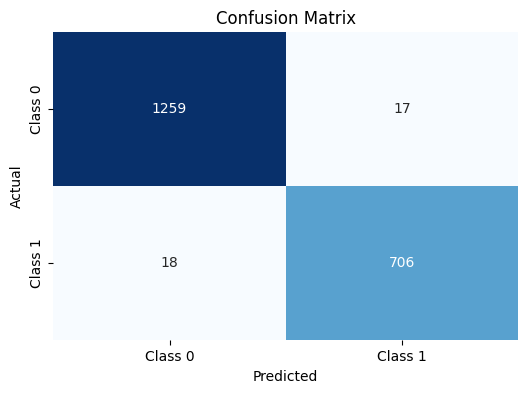

In [42]:
svm_clf = svc_raw_clf_res.best_estimator_
svm_clf.fit(X_train_val, clf_y_train_val)

print("SVM classifier test score: ", svm_clf.score(X_test, clf_y_test), "\n")

print(classification_report(
    y_true=clf_y_test, y_pred=svm_clf.predict(X_test),
    labels=[0, 1], target_names=["Unstable", "Stable"]
))
y_pred=svm_clf.predict(X_test)
cm = confusion_matrix(clf_y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


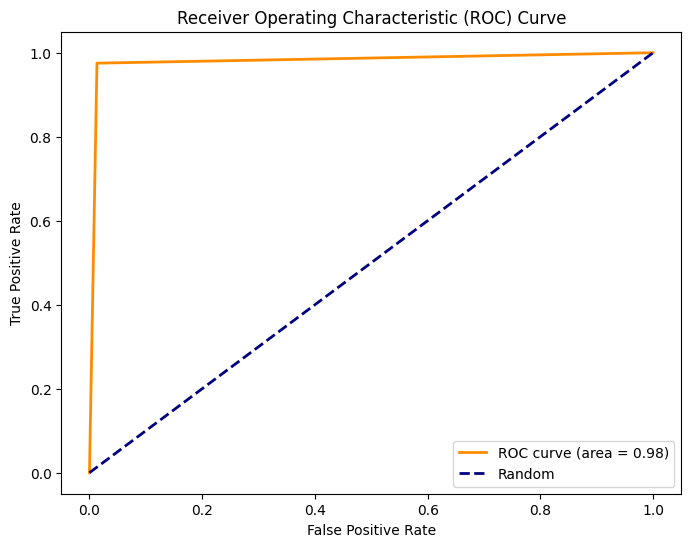

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test and y_score are your actual labels and predicted scores
fpr, tpr, thresholds = roc_curve(clf_y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

KNN

k-nearest neighbours makes predictions based on values of the nearest neighbours. For classification, this is summarised by a simple majority vote, whereas averaging is used for regression. This of course means hyperparameters related to the number of neighbours, how distances are calculated and how much weight is put on each neighbour's value affect the performance.

In [44]:
print("Typical `k` to start with (square root of number of samples): ",
      np.sqrt(X_train_val.shape[0]))

knn_params = {
    "transformer": transformers,
    "estimator__n_neighbors": [5, 15, 45, 90],  # default 5
    # distance function, default minkowski
    "estimator__metric": ["minkowski", "euclidean", "manhattan"],
    "estimator__weights": ["uniform", "distance"],  # default uniform
    "estimator__algorithm" : ["auto", "ball_tree", "kd_tree"]  # default auto
}

knc_raw_clf_res = gen_search_eval("knc", knn_params, "clf", "random")
print(f"\nBest classifier pipeline: {knc_raw_clf_res.best_estimator_}")

knc_clf_res = fmt_search_res(knc_raw_clf_res)
knc_clf_res.head(3)

Typical `k` to start with (square root of number of samples):  89.44271909999159
Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best classifier pipeline: Pipeline(steps=[('transformer', QuantileTransformer()),
                ('estimator',
                 KNeighborsClassifier(algorithm='ball_tree', metric='manhattan',
                                      n_neighbors=15, weights='distance'))])


,transformer,estimator__weights,estimator__n_neighbors,estimator__metric,estimator__algorithm,rank_test_score,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,std_train_score,std_test_score
33,QuantileTransformer(),distance,15,manhattan,kd_tree,1,0.043056,0.344827,1.0,0.904250,0.0,0.010734
11,QuantileTransformer(),distance,15,manhattan,ball_tree,1,0.051741,0.374181,1.0,0.904250,0.0,0.010734
34,RobustScaler(),distance,15,manhattan,ball_tree,3,0.024280,0.413372,1.0,0.903875,0.0,0.010668


KNN classifier test score:  0.909 

              precision    recall  f1-score   support

    Unstable       0.90      0.96      0.93      1276
      Stable       0.93      0.81      0.87       724

    accuracy                           0.91      2000
   macro avg       0.91      0.89      0.90      2000
weighted avg       0.91      0.91      0.91      2000



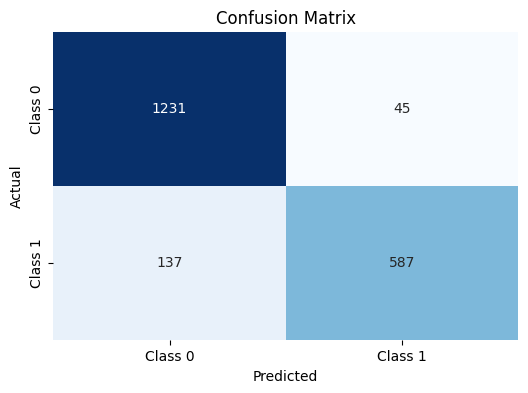

In [45]:
KNN_clf = knc_raw_clf_res.best_estimator_
KNN_clf.fit(X_train_val, clf_y_train_val)

print("KNN classifier test score: ", KNN_clf.score(X_test, clf_y_test), "\n")

print(classification_report(
    y_true=clf_y_test, y_pred=KNN_clf.predict(X_test),
    labels=[0, 1], target_names=["Unstable", "Stable"]
))
y_pred=KNN_clf.predict(X_test)
cm = confusion_matrix(clf_y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


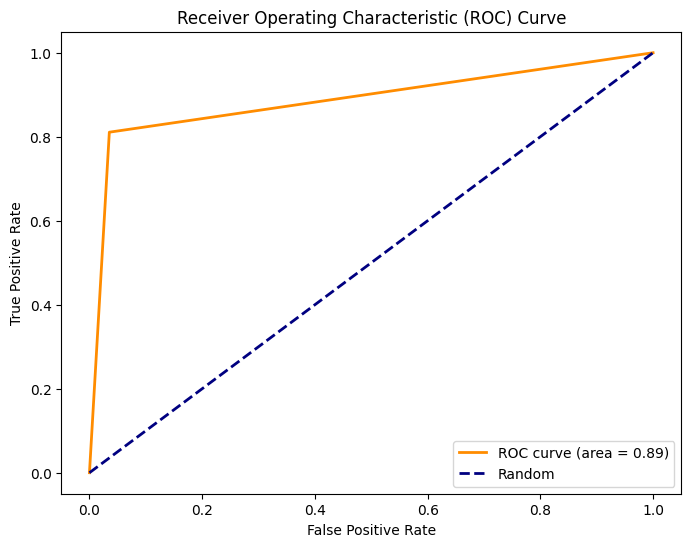

In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test and y_score are your actual labels and predicted scores
fpr, tpr, thresholds = roc_curve(clf_y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### Random Forests


In [47]:
rf_params = {
    "transformer": transformers,
    "estimator__n_estimators": [50, 100, 250, 500],  # default 100
    "estimator__max_depth": [15, 50, None],
    "estimator__min_samples_split": [2, 5, 10],  # default 2
    "estimator__min_samples_leaf": [1, 2, 5]  # default 1
}

rfc_raw_clf_res = gen_search_eval("rfc", rf_params, "clf", "random")
print(f"\nBest classifier pipeline: {rfc_raw_clf_res.best_estimator_}")

rfc_clf_res = fmt_search_res(rfc_raw_clf_res)
rfc_clf_res.head(3)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best classifier pipeline: Pipeline(steps=[('transformer', RobustScaler()),
                ('estimator',
                 RandomForestClassifier(max_depth=50, min_samples_split=5,
                                        n_estimators=500, random_state=1))])


,transformer,estimator__n_estimators,estimator__min_samples_split,estimator__min_samples_leaf,estimator__max_depth,rank_test_score,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,std_train_score,std_test_score
28,RobustScaler(),500,5,1,50.0,1,11.631694,0.219978,1.0,0.924125,0.0,0.004412
43,QuantileTransformer(),500,2,1,50.0,2,11.449748,0.270983,1.0,0.923875,0.0,0.006090
37,RobustScaler(),500,5,1,15.0,3,11.135246,0.255357,1.0,0.923250,0.0,0.004991


Random Forests classifier test score:  0.926 

              precision    recall  f1-score   support

    Unstable       0.93      0.96      0.94      1276
      Stable       0.93      0.86      0.89       724

    accuracy                           0.93      2000
   macro avg       0.93      0.91      0.92      2000
weighted avg       0.93      0.93      0.93      2000



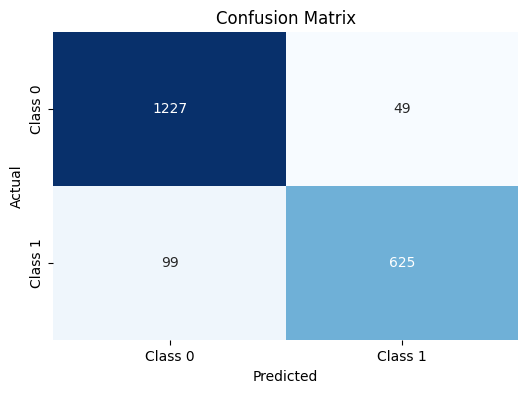

In [48]:
rf_clf = rfc_raw_clf_res.best_estimator_
rf_clf.fit(X_train_val, clf_y_train_val)

print("Random Forests classifier test score: ", rf_clf.score(X_test, clf_y_test), "\n")

print(classification_report(
    y_true=clf_y_test, y_pred=rf_clf.predict(X_test),
    labels=[0, 1], target_names=["Unstable", "Stable"]
))
y_pred=rf_clf.predict(X_test)
cm = confusion_matrix(clf_y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


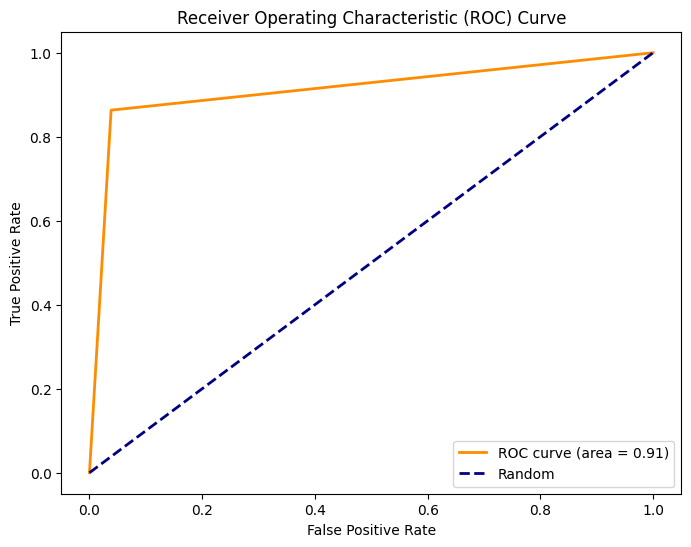

In [49]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test and y_score are your actual labels and predicted scores
fpr, tpr, thresholds = roc_curve(clf_y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Naive Bayes

In [53]:
nb_params = {
    "transformer": transformers,
}

nb_raw_clf_res = gen_search_eval("gNB", nb_params, "clf", "random")
print(f"\nBest classifier pipeline: {nb_raw_clf_res.best_estimator_}")

nb_clf_res = fmt_search_res(nb_raw_clf_res)
nb_clf_res.head(3)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=60. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best classifier pipeline: Pipeline(steps=[('transformer', QuantileTransformer()),
                ('estimator', GaussianNB())])


,transformer,rank_test_score,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,std_train_score,std_test_score
3,QuantileTransformer(),1,0.063379,0.008838,0.834562,0.834500,0.002308,0.007998
2,FunctionTransformer(func=<function <lambda> at...,2,0.010373,0.007137,0.834406,0.833875,0.002304,0.007659
0,StandardScaler(),2,0.023467,0.009281,0.834406,0.833875,0.002304,0.007659


Random Forests classifier test score:  0.8365 

              precision    recall  f1-score   support

    Unstable       0.83      0.93      0.88      1276
      Stable       0.84      0.67      0.75       724

    accuracy                           0.84      2000
   macro avg       0.84      0.80      0.81      2000
weighted avg       0.84      0.84      0.83      2000



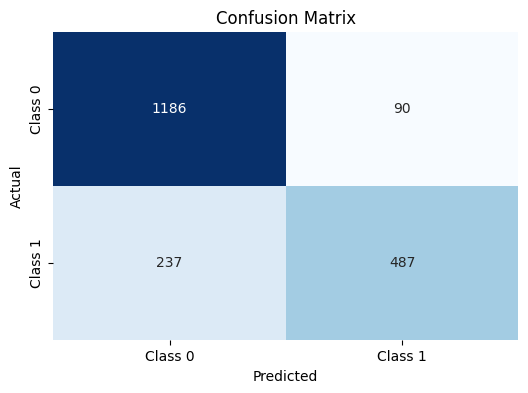

In [54]:
nb_clf = nb_raw_clf_res.best_estimator_
nb_clf.fit(X_train_val, clf_y_train_val)

print("Random Forests classifier test score: ", nb_clf.score(X_test, clf_y_test), "\n")

print(classification_report(
    y_true=clf_y_test, y_pred=nb_clf.predict(X_test),
    labels=[0, 1], target_names=["Unstable", "Stable"]
))
y_pred=nb_clf.predict(X_test)
cm = confusion_matrix(clf_y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


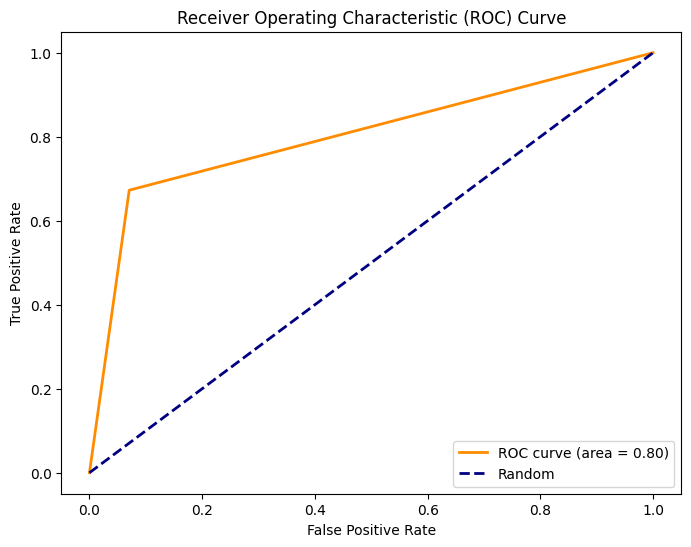

In [55]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test and y_score are your actual labels and predicted scores
fpr, tpr, thresholds = roc_curve(clf_y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Decision Trees

In [56]:
dt_params = {
    "transformer": transformers,
    "estimator__max_depth": [None, 5, 10, 20],
    "estimator__min_samples_split": [2, 5, 10],
    "estimator__min_samples_leaf": [1, 2, 5],
}

dtc_raw_clf_res = gen_search_eval("dtc", dt_params, "clf", "random")
print(f"\nBest classifier pipeline: {dtc_raw_clf_res.best_estimator_}")

dtc_clf_res = fmt_search_res(dtc_raw_clf_res)
dtc_clf_res.head(3)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best classifier pipeline: Pipeline(steps=[('transformer', StandardScaler()),
                ('estimator',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=5,
                                        min_samples_split=10))])


,transformer,estimator__min_samples_split,estimator__min_samples_leaf,estimator__max_depth,rank_test_score,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,std_train_score,std_test_score
36,StandardScaler(),10,5,10.0,1,0.081874,0.003886,0.942156,0.859000,0.001741,0.009973
18,QuantileTransformer(),5,5,NaN,2,0.334939,0.029113,0.948250,0.858875,0.001704,0.010513
29,QuantileTransformer(),10,5,NaN,3,0.202863,0.012707,0.948250,0.858375,0.001598,0.011185


Random Forests classifier test score:  0.8455 

              precision    recall  f1-score   support

    Unstable       0.87      0.89      0.88      1276
      Stable       0.80      0.76      0.78       724

    accuracy                           0.85      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.84      0.85      0.84      2000



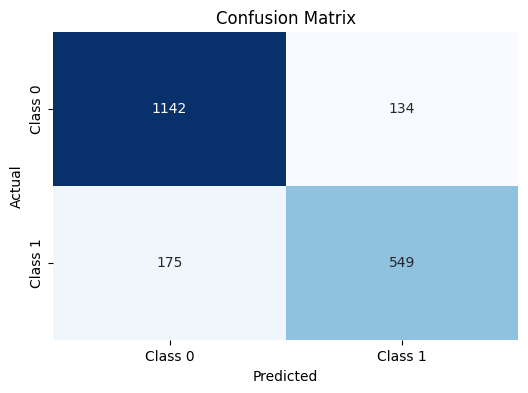

In [57]:
dt_clf = dtc_raw_clf_res.best_estimator_
dt_clf.fit(X_train_val, clf_y_train_val)

print("Random Forests classifier test score: ", dt_clf.score(X_test, clf_y_test), "\n")

print(classification_report(
    y_true=clf_y_test, y_pred=dt_clf.predict(X_test),
    labels=[0, 1], target_names=["Unstable", "Stable"]
))
y_pred=dt_clf.predict(X_test)
cm = confusion_matrix(clf_y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


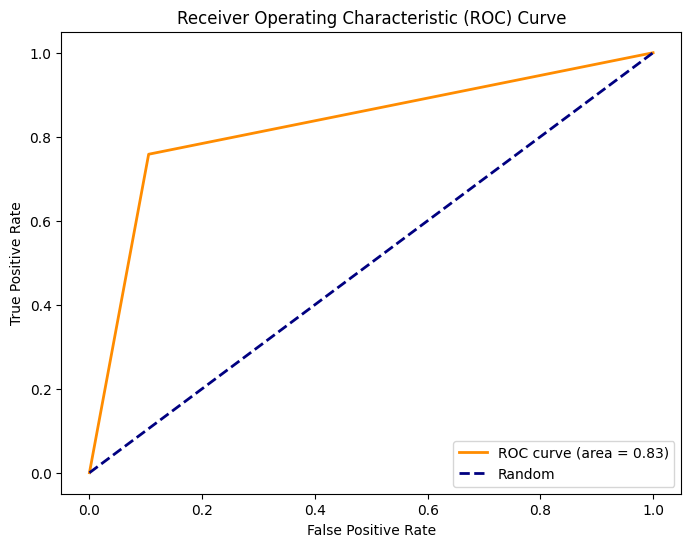

In [58]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test and y_score are your actual labels and predicted scores
fpr, tpr, thresholds = roc_curve(clf_y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Logistic Regression

 In logistic regression, the results are then transformed into probabilities. I explored parameters controlling regularisation type and strength, as well as the algorithm used to find the optimal coefficients.

In [59]:
log_reg_params = [
    # compatible with both l1 (lasso) and l2 (ridge)
    {"estimator__solver": ["saga", "liblinear"],
     "estimator__penalty": ["l1", "l2"]},
    {"estimator__solver": ["lbfgs", "newton-cg", "sag"],  # default lbfgs
     "estimator__penalty": ["l2"]}]

for param_dict in [0, 1]:
    log_reg_params[param_dict].update({"transformer": transformers,
                                       # inverse of lambda, default 1
                                      "estimator__C": np.logspace(-2, 2, 5)})

log_reg_raw_clf_res = gen_search_eval("log_reg", log_reg_params, "clf", "grid")
print(f"\nBest performing pipeline: {log_reg_raw_clf_res.best_estimator_}")

log_reg_clf_res = fmt_search_res(log_reg_raw_clf_res)
log_reg_clf_res.head(3)

Fitting 5 folds for each of 140 candidates, totalling 700 fits

Best performing pipeline: Pipeline(steps=[('transformer', RobustScaler()),
                ('estimator',
                 LogisticRegression(C=0.01, random_state=1, solver='saga'))])


,estimator__C,estimator__penalty,estimator__solver,transformer,rank_test_score,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,std_train_score,std_test_score
81,0.01,l2,lbfgs,RobustScaler(),1,0.022631,0.004121,0.813875,0.815,0.001995,0.009569
85,0.01,l2,newton-cg,RobustScaler(),1,0.032900,0.004166,0.813875,0.815,0.001995,0.009569
89,0.01,l2,sag,RobustScaler(),1,0.045371,0.003958,0.813875,0.815,0.001995,0.009569


Logistic Regression classifier test score:  0.82 

              precision    recall  f1-score   support

    Unstable       0.83      0.91      0.87      1276
      Stable       0.80      0.67      0.73       724

    accuracy                           0.82      2000
   macro avg       0.82      0.79      0.80      2000
weighted avg       0.82      0.82      0.82      2000



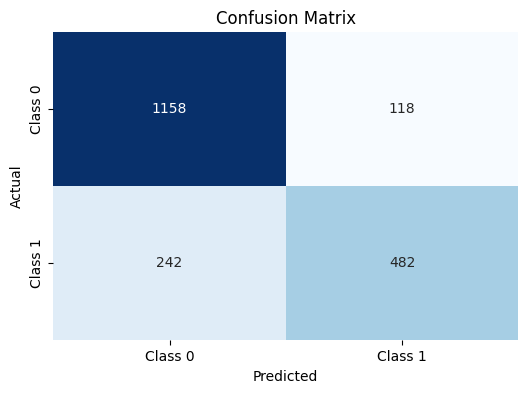

In [60]:
lr_clf = log_reg_raw_clf_res.best_estimator_
lr_clf.fit(X_train_val, clf_y_train_val)

print("Logistic Regression classifier test score: ", lr_clf.score(X_test, clf_y_test), "\n")

print(classification_report(
    y_true=clf_y_test, y_pred=lr_clf.predict(X_test),
    labels=[0, 1], target_names=["Unstable", "Stable"]
))
y_pred=lr_clf.predict(X_test)
cm = confusion_matrix(clf_y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


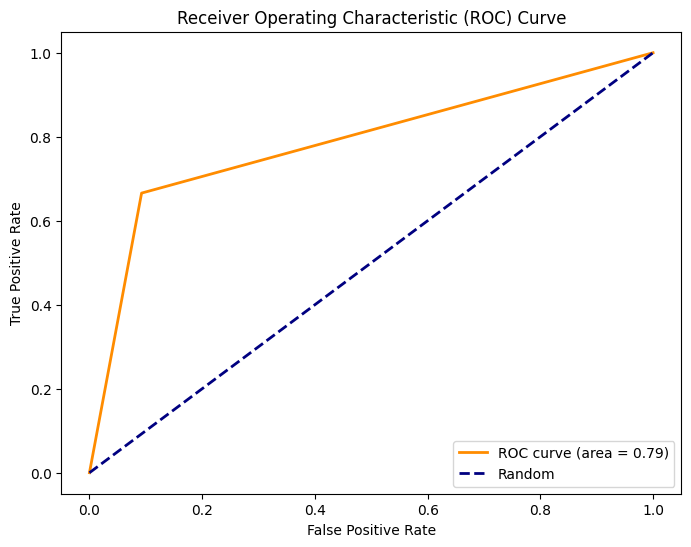

In [61]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test and y_score are your actual labels and predicted scores
fpr, tpr, thresholds = roc_curve(clf_y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

##Optimisation summary



In [62]:
def get_tuned_score(est_name:str, task:str):
    score = globals()[f"{est_name}_raw_{task}_res"].best_score_
    return score

summary_df_display_text = ""

for bl_df, mode in zip([blc_no_pwr], ["clf"]):
    caption = "classifier summary"
    html_text = (
        bl_df
        .pipe(pd.pivot_table,
              values="val_score",
              index="estimator",
              aggfunc=np.mean)
        .rename(columns={"val_score": "baseline"})
        .reset_index()
        .sort_values("baseline", ascending=False)
        .assign(tuned = lambda x: x["estimator"].apply(get_tuned_score, task=mode),
                diff = lambda x: x["tuned"] - x["baseline"])

        # display options
        .style.format("{:.1%}", subset = ["baseline", "tuned", "diff"])
        .set_table_attributes("style='display:inline'")
        .set_caption(caption)._repr_html_()
    )
    summary_df_display_text = summary_df_display_text + html_text + "\xa0" * 2
display_html(summary_df_display_text, raw=True)

,estimator,baseline,tuned,diff
5,svc,96.8%,97.3%,0.6%
4,rfc,92.0%,92.4%,0.4%
2,knc,89.2%,90.4%,1.2%
0,dtc,85.0%,85.9%,0.9%
1,gNB,83.4%,83.5%,0.1%
3,log_reg,81.3%,81.5%,0.2%


Overall, optimisation maintained or slightly improved accuracy in all classifiers (by 0.1 - 1.5%) with the best performances coming from the SVM classifier.

Testing the final classifier on the held out test data scored 98.3% accuracy. Precision, recall and the resulting F1 scores are high in both classes, and the ROC curve looks great. Of course a score this high is extremely rare when working with real data, and suggests there isn't a lot of noise in this simulated data set.

-------------------------------------------------------------